## Sekkyone - IPV6 Network Experiment - IoT Course 2020/2021

#### Radio settings

The following cells give us random value for *CHANNEL*, in order to avoid busy channels and possible collisions

In [1]:
%env SITE=saclay

env: SITE=saclay


In [2]:
%env LOGIN=giaccone

env: LOGIN=giaccone


In [3]:
import random
channel = random.randint(11, 26)
print('Use CHANNEL={}'.format(channel))

Use CHANNEL=23


In [4]:
print(channel)

23


In [5]:
%env CHANNEL=23

env: CHANNEL=23


## Experiment Submitting

In order to start our experiment, we will use, at the moment, the following configuration of nodes:
* n.1  a8 node  -> Its purpose is to provide us an MQTT-Bridge beetween nodes and IoT Corre
* n.1  m3 node  -> It will be our border router
* n.2+ m3 nodes -> They will run our application firmware

In [14]:
!iotlab-experiment submit -n riot_m3 -d 120 -l 4,archi=m3:at86rf231+site=$SITE,,sekkyone_mesh_m3 -l 1,archi=a8:at86rf231+site=$SITE,,sekkyone_mesh_a8

{
    "id": 270129
}


In [15]:
!iotlab-experiment wait --timeout 60 --cancel-on-timeout

Waiting that experiment 270129 gets in state Running
"Running"


Set the *EXPERIMENT_ID* output as a environmental variable and use the following commands for additional info about the reserved nodes:

In [17]:
%env EXPERIMENT_ID=270129

env: EXPERIMENT_ID=270129


In [ ]:
!iotlab-experiment get -i $EXPERIMENT_ID -p

In [ ]:
!iotlab-experiment get -i $EXPERIMENT_ID -n

Now, set, as environmental variables, *ID*'s of the m3 and a8 nodes

In [19]:
%env A8_NODE=100
%env M3_BORDER=9
%env M3_NODE_1=10
%env M3_NODE_2=11
%env M3_NODE_3=12

env: A8_NODE=100
env: M3_BORDER=9
env: M3_NODE_1=10
env: M3_NODE_2=11
env: M3_NODE_3=12


## Build and Flash firmwares

Open a Jupyter terminal (use `File > New > Terminal`) and run the following commands from it.

The following command needs to be run ONLY once

We will use minimum 3 distrinct terminals for building and flashing firmwares

### Border Router
Execute the following commands (in terminal #1), by replacing the \<PLACEHOLDERS> with real info:

`source /opt/riot.source`

`cd RIOT`

`make ETHOS_BAUDRATE=500000 DEFAULT_CHANNEL=<CHANNEL> BOARD=iotlab-m3 -C examples/gnrc_border_router clean all`

`iotlab-node --flash examples/gnrc_border_router/bin/iotlab-m3/gnrc_border_router.elf -l saclay,m3,<ID>`

`sudo ethos_uhcpd.py m3-<ID> tap<K> 2001:660:3207:04c1::1/64`

Where:
1. `DEFAULT_CHANNEL` refers to the ENV variable added on top
2. `ID` is the M3 node number (ex: m3-1, ID is "1")
3. `K` is the tap interface number (ex: tap0, tap1...)

Always check that the interface and the channel are free

### MQTT-SN broker
We will use mosquitto.rsmb for communicating with the EC2 machine. Execute the following commands (in terminal #2):

Create the following file inside the A8 folder:


`ssh root@node-a8-<ID>`


`cd A8`

`ip -6 -o addr show eth0` // TO GET THE IP Address of the MQTT broker, global link

`broker_mqtts config.conf`

### Sekkyone application firmware
For all the remaining reserved m3 nodes, execute the following commands:

`source /opt/riot.source`

`cd dev`

where dev is the folder where `main.c` and `makefile` files are contained

`make DEFAULT_CHANNEL=<CHANNEL> SERVER_ADDR=<MQTT_SERVER_ADDR> EMCUTE_ID=station<K> BOARD=iotlab-m3 -C . clean all`

`iotlab-node --flash ./bin/iotlab-m3/sekkyone_mesh_network.elf -l saclay,m3,<ID>`

Eventually, nc to the node\[s\] to see if everything works fine:

`nc m3-<ID> 20000`

### Free up the resources

Once done, stop your experiment to free up the experiment nodes:

In [20]:
!iotlab-experiment stop

{
    "id": 270129,
    "status": "Delete request registered"
}


## Performance Evaluation

In [21]:
!mkdir perf_last/$EXPERIMENT_ID
!mkdir perf_last/$EXPERIMENT_ID/consumption
!mkdir perf_last/$EXPERIMENT_ID/radio

Let's copy consumption .oml files from ssh frontend to jupyter

In [22]:
!scp -o StrictHostKeyChecking=no $LOGIN@$SITE.iot-lab.info:~/.iot-lab/$EXPERIMENT_ID/consumption/m3_$M3_BORDER.oml perf_last/$EXPERIMENT_ID/consumption/consumption_m3_border.oml
!scp -o StrictHostKeyChecking=no $LOGIN@$SITE.iot-lab.info:~/.iot-lab/$EXPERIMENT_ID/consumption/m3_$M3_NODE_1.oml perf_last/$EXPERIMENT_ID/consumption/consumption_$M3_NODE_1.oml
!scp -o StrictHostKeyChecking=no $LOGIN@$SITE.iot-lab.info:~/.iot-lab/$EXPERIMENT_ID/consumption/m3_$M3_NODE_2.oml perf_last/$EXPERIMENT_ID/consumption/consumption_$M3_NODE_2.oml
!scp -o StrictHostKeyChecking=no $LOGIN@$SITE.iot-lab.info:~/.iot-lab/$EXPERIMENT_ID/consumption/m3_$M3_NODE_3.oml perf_last/$EXPERIMENT_ID/consumption/consumption_$M3_NODE_3.oml
!scp -o StrictHostKeyChecking=no $LOGIN@$SITE.iot-lab.info:~/.iot-lab/$EXPERIMENT_ID/consumption/a8_$A8_NODE.oml perf_last/$EXPERIMENT_ID/consumption/consumption_a8.oml

m3_9.oml                                      100% 3614KB  13.9MB/s   00:00    
m3_10.oml                                     100% 3644KB  22.7MB/s   00:00    
m3_11.oml                                     100% 3553KB  24.8MB/s   00:00    
m3_12.oml                                     100% 3593KB  26.4MB/s   00:00    
a8_100.oml                                    100% 3555KB  27.6MB/s   00:00    


And now copy radio .oml files

In [23]:
!scp -o StrictHostKeyChecking=no $LOGIN@$SITE.iot-lab.info:~/.iot-lab/$EXPERIMENT_ID/radio/m3_$M3_BORDER.oml perf_last/$EXPERIMENT_ID/radio/radio_m3_border.oml
!scp -o StrictHostKeyChecking=no $LOGIN@$SITE.iot-lab.info:~/.iot-lab/$EXPERIMENT_ID/radio/m3_$M3_NODE_1.oml perf_last/$EXPERIMENT_ID/radio/radio_$M3_NODE_1.oml
!scp -o StrictHostKeyChecking=no $LOGIN@$SITE.iot-lab.info:~/.iot-lab/$EXPERIMENT_ID/radio/m3_$M3_NODE_2.oml perf_last/$EXPERIMENT_ID/radio/radio_$M3_NODE_2.oml
!scp -o StrictHostKeyChecking=no $LOGIN@$SITE.iot-lab.info:~/.iot-lab/$EXPERIMENT_ID/radio/m3_$M3_NODE_3.oml perf_last/$EXPERIMENT_ID/radio/radio_$M3_NODE_3.oml

m3_9.oml                                      100%  159KB   5.4MB/s   00:00    
m3_10.oml                                     100%  159KB   5.4MB/s   00:00    
m3_11.oml                                     100%  159KB   5.3MB/s   00:00    
m3_12.oml                                     100%  159KB   5.3MB/s   00:00    


#### Analyze CONSUMPTION data

In [24]:
!ls perf_last/$EXPERIMENT_ID/consumption

consumption_10.oml  consumption_12.oml	consumption_m3_border.oml
consumption_11.oml  consumption_a8.oml


In [25]:
import pandas

In [60]:
dataset_consumption = pandas.read_csv("./perf_last/270114/consumption/consumption_a8.oml", sep='\t', skiprows=9, header=0, names=["timestamp_s", "timestamp_us", 'ign1', 'ign2', "power", "voltage", "current"])

In [61]:
dataset_consumption

,timestamp_s,timestamp_us,ign1,ign2,power,voltage,current
2.993589,1,2,1624453183,124844,1.844845,4.93000,0.374170
2.993680,1,3,1624453183,191090,1.861327,4.93000,0.377540
2.993894,1,4,1624453183,257335,1.844234,4.93000,0.374024
2.993986,1,5,1624453183,323581,1.863769,4.93000,0.377979
2.994077,1,6,1624453183,389827,1.858886,4.93000,0.377076
...,...,...,...,...,...,...,...
732.552499,1,11025,1624453913,538048,2.314908,4.92500,0.470063
732.873263,1,11026,1624453913,604325,2.286216,4.92500,0.464227
732.874209,1,11027,1624453913,670571,2.265460,4.92375,0.460051
732.874819,1,11028,1624453913,736847,2.297815,4.92375,0.466669


Text(0.5, 0, 'Time (ms)')

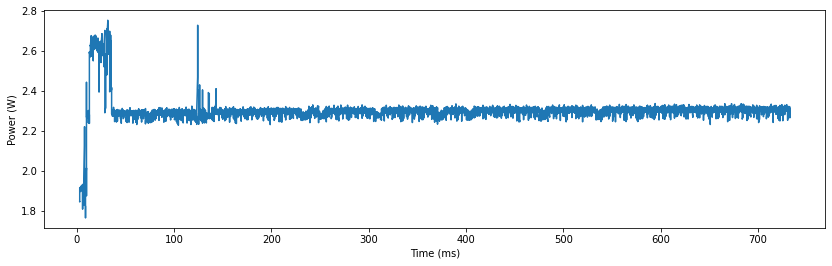

In [62]:
ax = dataset_consumption.power.plot(figsize=(14,4), label='Power (W)')
ax.set_ylabel('Power (W)')
ax.set_xlabel('Time (ms)')

Text(0.5, 0, 'Time (ms)')

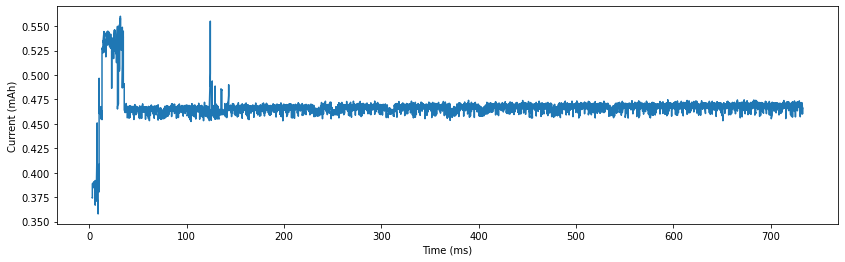

In [63]:
ax = dataset_consumption.current.plot(figsize=(14,4), label='Current (mAh)')
ax.set_ylabel('Current (mAh)')
ax.set_xlabel('Time (ms)')

Text(0.5, 0, 'Time (ms)')

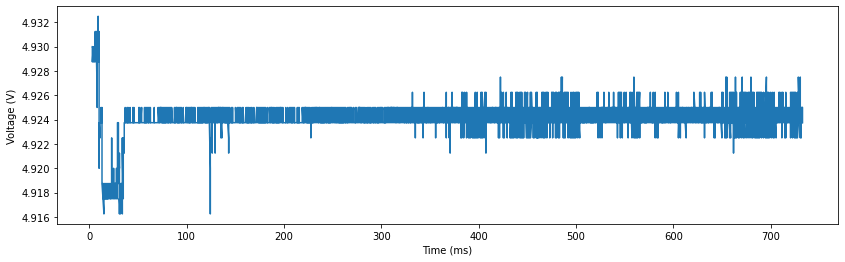

In [65]:
ax = dataset_consumption.voltage.plot(figsize=(14,4), label='Voltage (V)')
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (ms)')

#### Analyze RADIO data

In [32]:
!ls perf_last/$EXPERIMENT_ID/radio

radio_10.oml  radio_11.oml  radio_12.oml  radio_m3_border.oml


In [57]:
dataset_radio = pandas.read_csv("./perf_last/270114/radio/radio_m3_border.oml", sep='\t', skiprows=9, header=0, names=["timestamp_s", "timestamp_us", "channel", "rssi"])

In [58]:
dataset_radio

,,,timestamp_s,timestamp_us,channel,rssi
8.996079,2,2,1624453189,992297,20,-91
8.999558,2,3,1624453190,992304,20,-91
11.994276,2,4,1624453191,992310,20,-91
11.994826,2,5,1624453192,992316,20,-91
11.995436,2,6,1624453193,992322,20,-91
...,...,...,...,...,...,...
729.000311,2,721,1624453908,998896,20,-91
729.000494,2,722,1624453909,998902,20,-91
729.000677,2,723,1624453910,998877,20,-91
731.939153,2,724,1624453911,998914,20,-91


Text(0, 0.5, 'RSSI (dBm)')

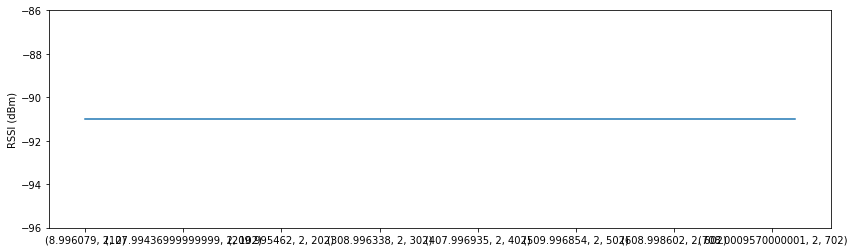

In [59]:
ax = dataset_radio.rssi.plot(figsize=(14,4), label='RSSI (dBm)')
ax.set_ylabel('RSSI (dBm)')
